In [1]:
%%capture --no-stderr
%pip install -U --quiet langchain==0.2.12 langchain-core==0.2.27 langchain-openai==0.1.20 langgraph==0.1.19 langsmith==0.1.96  numexpr langchainhub sqlalchemy langchain-community

In [2]:
import getpass
import os

from langchain_openai import ChatOpenAI

# Imported from the https://github.com/langchain-ai/langgraph/tree/main/examples/plan-and-execute repo
from tools.image_analysis_tool import get_image_analysis_tools
from tools.text2SQL import get_text2SQL_tools

from langchain_core.pydantic_v1 import BaseModel, Field
from src.joiner import *
from src.build_graph import graph_construction, graph_construction_report, graph_construction_m3ae

from langchain_core.messages import (
    BaseMessage,
    FunctionMessage,
    HumanMessage,
    SystemMessage,
)

from src.planner import *
from src.task_fetching_unit import *
from src.joiner import *
from src.joiner import parse_joiner_output
from src.utils import _get_db_schema
from typing import Dict
from src.utils import correct_malformed_json, CustomJSONEncoder
import ast
# from langgraph.checkpoint.sqlite import SqliteSaver


from langgraph.graph import END, MessageGraph, START,StateGraph

def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")

_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("LANGCHAIN_API_KEY")
_set_if_undefined("LANGCHAIN_API_YI_KEY")
os.environ["LANGCHAIN_API_KEY"] = os.environ["LANGCHAIN_API_YI_KEY"]
# _set_if_undefined("TAVILY_API_KEY")
# # Optional, add tracing in LangSmith

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "XMODE"



In [3]:
model="gpt-4o" #gpt-4-turbo-preview
#memory = SqliteSaver.from_conn_string(":memory:")

chain = graph_construction_m3ae(model)

/home/ubuntu/.pyenv/versions/3.10.8/envs/m3lx/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: LangChain has introduced a method called `with_structured_output` that is available on ChatModels capable of tool calling. You can read more about the method here: <https://python.langchain.com/docs/modules/model_io/chat/structured_output/>.Please follow our extraction use case documentation for more guidelines on how to do information extraction with LLMs. <https://python.langchain.com/docs/use_cases/extraction/>. If you notice other issues, please provide feedback here: <https://github.com/langchain-ai/langchain/discussions/18154>
  warn_deprecated(


In [4]:

db_path="/home/ubuntu/workspace/XMODE-LLMCompiler/mimic_iv_cxr.db"
# "enumerate all detected abnormalities, given the study 57883509."
example_question="Is there any evidence in the most recent study for patient 13859433 this year indicating the continued absence of anatomical findings in the left hilar structure compared to the previous study?"
# tables=['TB_CXR','PATIENTS']
# tables= [t.upper()for t in tables]
# id= 2000
# database_schema =_get_db_schema(db_path, tables=None)
database_schema = None
#"could you list all anatomical locations related to any diseases newly detected in the 55411906 study versus the findings of the 59867439 study?"
#"how many days have elapsed from the first time patient 19631398's chest x-ray demonstrated any anatomical findings in the mediastinum in 2103?"
#"what's the count of patients whose chest x-ray studies since 15 month ago demonstrated any anatomical findings in the cardiac silhouette?"
#"did patient 12354194 undergo the procedure on two vessels procedure within the same month after a chest x-ray study revealed any anatomical findings until 2 year ago?"

inputs = {"question": example_question, "database_schema":database_schema}
# config = {"configurable": {"thread_id": "xmode-2000"}}
inputs=[HumanMessage(content=[inputs])]

for output in chain.stream(inputs, stream_mode="values"):
   print(output)
   # for key, value in output.items():
   #    print(f"output from node '{key}'")
   #    print("-----")
   #    print(value)
# _steps_dict = chain.stream(
#     [
#         HumanMessage(
#             content=[chain_input]
#         ),
    
#     ],
#     # config=config,
#     #stream_mode="debug",
# )



[HumanMessage(content=[{'question': 'Is there any evidence in the most recent study for patient 13859433 this year indicating the continued absence of anatomical findings in the left hilar structure compared to the previous study?', 'database_schema': None}], id='a1ff2fff-1319-444d-bed7-04e0e7eacf09')]
chain_input: {'problem': 'Retrieve the most recent study for patient 13859433 this year.', 'db_schema': '{"ADMISSIONS": {"COL": [["row_id", "INTEGER"], ["subject_id", "INTEGER"], ["hadm_id", "INTEGER"], ["admittime", "TEXT"], ["dischtime", "TEXT"], ["admission_type", "TEXT"], ["admission_location", "TEXT"], ["discharge_location", "TEXT"], ["insurance", "TEXT"], ["language", "TEXT"], ["marital_status", "TEXT"], ["age", "INTEGER"]], "FK": []}, "CHARTEVENTS": {"COL": [["row_id", "INTEGER"], ["subject_id", "INTEGER"], ["hadm_id", "INTEGER"], ["stay_id", "INTEGER"], ["charttime", "TEXT"], ["itemid", "INTEGER"], ["valuenum", "REAL"], ["valueuom", "TEXT"]], "FK": []}, "COST": {"COL": [["row_id"

In [5]:
to_json=[]
for msg in output:
      value= msg.to_json()['kwargs']
      to_json.append(value)

In [6]:
to_json

[{'content': [{'question': 'Is there any evidence in the most recent study for patient 13859433 this year indicating the continued absence of anatomical findings in the left hilar structure compared to the previous study?',
    'database_schema': None}],
  'type': 'human',
  'id': '77a0cbfc-ad86-4615-8304-a1200d390492'},
 {'content': "['TB_CXR_PLUS']",
  'additional_kwargs': {'idx': 1,
   'args': {'problem': 'Find the most recent study for patient 13859433 this year indicating the continued absence of anatomical findings in the left hilar structure compared to the previous study.',
    'context': None}},
  'type': 'function',
  'name': 'intent_tables',
  'id': 'e28bdf0c-baef-4eaf-a563-9bcad6017052'},
 {'content': "{'status': 'success', 'data': [{'study_id': 56222792}]}",
  'additional_kwargs': {'idx': 2,
   'args': {'problem': 'Retrieve the most recent study ID for patient 13859433 conducted this year.',
    'context': '$1'}},
  'type': 'function',
  'name': 'text2SQL',
  'id': 'b1ddd2

In [7]:

ast.literal_eval(output[-1].content)

{'Summary': 'Unable to compare anatomical findings in the left hilar structure with previous studies for patient 13859433 as there is no previous study data.',
 'details': 'The most recent study conducted this year for patient 13859433 indicates evidence of anatomical findings in the left hilar structure. However, there is no available data for any previous study conducted prior to this year, making it impossible to compare or confirm the continued absence or presence of anatomical findings in the left hilar structure.',
 'source': 'Most recent study ID 56222792 for patient 13859433 and image analysis results.',
 'inference': 'yes',
 'extra explanation': 'The absence of previous study data means a comparison cannot be made, but the current study shows findings in the left hilar structure.'}

In [8]:
from langchain.load.dump import dumps
import json
from pprint import pprint

# print(output[-1].pretty_print())

    
# for message in output:
  
# #    message.pretty_print()
#     pprint(message)  




with open('steps_dict.json', 'w', encoding='utf-8') as f:
        json.dump(to_json, f, ensure_ascii=False, indent=4)

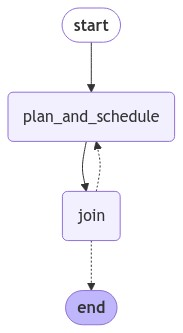

In [9]:
from IPython.display import Image, display


display(Image(chain.get_graph().draw_mermaid_png()))


https://smith.langchain.com/public/c9acfa5f-c8e2-4203-bb48-9ce046621f09/r

In [10]:
import ast
rs="{'Summary': 'No new diseases found in the right lower lung zone.', 'details': 'In the last and previous studies for patient 19103929 this year, there are no visible diseases in the right lower lung zone.', 'source': 'Image analysis of the last and previous studies.', 'inference': 'no', 'extra explanation': 'Both the last and previous studies show no diseases in the right lower lung zone.'}"
print(ast.literal_eval(rs))

{'Summary': 'No new diseases found in the right lower lung zone.', 'details': 'In the last and previous studies for patient 19103929 this year, there are no visible diseases in the right lower lung zone.', 'source': 'Image analysis of the last and previous studies.', 'inference': 'no', 'extra explanation': 'Both the last and previous studies show no diseases in the right lower lung zone.'}


In [11]:
# test get_table_info_dict
from src.sql_database import SQLDatabase
from sqlalchemy import create_engine
db_path="/home/ubuntu/workspace/XMODE-LLMCompiler/mimic_iv_cxr.db"
engine = create_engine(f'sqlite:///{db_path}')  # replace with your actual database connection string
database = SQLDatabase(engine)
table_info_dict = database.get_table_info_dict(None, False, False)

In [12]:
import json
json_str = json.dumps(table_info_dict)

In [13]:
json_str

'{"ADMISSIONS": {"COL": [["row_id", "INTEGER"], ["subject_id", "INTEGER"], ["hadm_id", "INTEGER"], ["admittime", "TEXT"], ["dischtime", "TEXT"], ["admission_type", "TEXT"], ["admission_location", "TEXT"], ["discharge_location", "TEXT"], ["insurance", "TEXT"], ["language", "TEXT"], ["marital_status", "TEXT"], ["age", "INTEGER"]], "FK": []}, "CHARTEVENTS": {"COL": [["row_id", "INTEGER"], ["subject_id", "INTEGER"], ["hadm_id", "INTEGER"], ["stay_id", "INTEGER"], ["charttime", "TEXT"], ["itemid", "INTEGER"], ["valuenum", "REAL"], ["valueuom", "TEXT"]], "FK": []}, "COST": {"COL": [["row_id", "INTEGER"], ["subject_id", "INTEGER"], ["hadm_id", "REAL"], ["event_type", "TEXT"], ["event_id", "INTEGER"], ["chargetime", "TEXT"], ["cost", "REAL"]], "FK": []}, "D_ICD_DIAGNOSES": {"COL": [["row_id", "INTEGER"], ["icd_code", "TEXT"], ["long_title", "TEXT"]], "FK": []}, "D_ICD_PROCEDURES": {"COL": [["row_id", "INTEGER"], ["icd_code", "TEXT"], ["long_title", "TEXT"]], "FK": []}, "D_ITEMS": {"COL": [["ro

In [14]:
table_info_dict

{'ADMISSIONS': {'COL': [['row_id', 'INTEGER'],
   ['subject_id', 'INTEGER'],
   ['hadm_id', 'INTEGER'],
   ['admittime', 'TEXT'],
   ['dischtime', 'TEXT'],
   ['admission_type', 'TEXT'],
   ['admission_location', 'TEXT'],
   ['discharge_location', 'TEXT'],
   ['insurance', 'TEXT'],
   ['language', 'TEXT'],
   ['marital_status', 'TEXT'],
   ['age', 'INTEGER']],
  'FK': []},
 'CHARTEVENTS': {'COL': [['row_id', 'INTEGER'],
   ['subject_id', 'INTEGER'],
   ['hadm_id', 'INTEGER'],
   ['stay_id', 'INTEGER'],
   ['charttime', 'TEXT'],
   ['itemid', 'INTEGER'],
   ['valuenum', 'REAL'],
   ['valueuom', 'TEXT']],
  'FK': []},
 'COST': {'COL': [['row_id', 'INTEGER'],
   ['subject_id', 'INTEGER'],
   ['hadm_id', 'REAL'],
   ['event_type', 'TEXT'],
   ['event_id', 'INTEGER'],
   ['chargetime', 'TEXT'],
   ['cost', 'REAL']],
  'FK': []},
 'D_ICD_DIAGNOSES': {'COL': [['row_id', 'INTEGER'],
   ['icd_code', 'TEXT'],
   ['long_title', 'TEXT']],
  'FK': []},
 'D_ICD_PROCEDURES': {'COL': [['row_id', 'INTE

In [6]:
from src.utils import correct_malformed_json
import ast
s = "{'question': 'have any tubes/lines related to both the abdomen and the right lung been noticed, given the first study of patient 19243401 on 12/this year?', 'context': '{{\"image_id\":\"46ee8707-81386f73-3ff804c3-92e6044b-dce8d6b2\",\"study_id\":52268471}}'}"
context=correct_malformed_json(s)
context = [ast.literal_eval(context)]



In [7]:
context

[{'question': 'have any tubes/lines related to both the abdomen and the right lung been noticed, given the first study of patient 19243401 on 12/this year?',
  'context': '{{"image_id":"46ee8707-81386f73-3ff804c3-92e6044b-dce8d6b2","study_id":"52268471"}}'}]